# Data Description

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.


## File descriptions

sales_train.csv - the training set. Daily historical data from January 2013 to October 2015. <br> test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.<br>sample_submission.csv - a sample submission file in the correct format.<br>items.csv - supplemental information about the items/products.<br>item_categories.csv  - supplemental information about the items categories.<br>shops.csv- supplemental information about the shops.


## Data fields
ID - an Id that represents a (Shop, Item) tuple within the test set<br>shop_id - unique identifier of a shop<br>item_id - unique identifier of a product<br>item_category_id - unique identifier of item category<br>item_cnt_day - number of products sold. You are predicting a monthly amount of this measure<br>item_price - current price of an item<br>date - date in format dd/mm/yyyy<br>date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33<br>item_name - name of item<br>shop_name - name of shop<br>item_category_name - name of item category

This dataset is permitted to be used for any purpose, including commercial use.

# Notebook Imports and Loading the Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
sales_train = pd.read_csv('data//sales_train.csv')
shops = pd.read_csv('data//shops.csv')
items = pd.read_csv('data//items.csv')
items_cat = pd.read_csv('data//item_categories.csv')
sales_test= pd.read_csv('data//test.csv')

# Understanding the Dataset (EDA + Data Preprocessing)

## Sales Train Dataset

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Convert "date" column to datetime format

In [5]:
sales_train["date"] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")

In [6]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


Checking missing values:

In [7]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [8]:
sales_train.shape

(2935849, 6)

Checking dublicate rows:

In [9]:
sales_train[sales_train.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,2013-01-05,0,54,20130,149.0,1.0
76962,2013-01-05,0,54,20130,149.0,1.0
1435365,2014-02-23,13,50,3423,999.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496765,2014-03-23,14,21,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671872,2014-05-01,16,50,3423,999.0,1.0
1671873,2014-05-01,16,50,3423,999.0,1.0
1866322,2014-07-12,18,25,3423,999.0,1.0
1866340,2014-07-12,18,25,3423,999.0,1.0


In [10]:
len(sales_train[sales_train.duplicated()])

6

There are 6 dublicate rows, let's drop them:

In [11]:
sales_train.drop(sales_train[sales_train.duplicated()].index, axis=0, inplace=True)

In [12]:
sales_train[sales_train.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [13]:
sales_train.shape

(2935843, 6)

## Sales Test Dataset

In [14]:
sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [15]:
sales_test.shape

(214200, 3)

In [16]:
sales_test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [17]:
sales_test[sales_test.duplicated(keep=False)]

,ID,shop_id,item_id


In [18]:
print(sorted(sales_test["shop_id"].unique()))

[2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59]


## Shops Dataset

In [19]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


It was observed some special characters in shop_name columns

In [20]:
shops.shape

(60, 2)

In [21]:
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [22]:
shops[shops.duplicated(keep=False)]

,shop_name,shop_id


In [23]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


to remove special characters in columns:

In [24]:
def name_correction(x):
    x = x.lower() # all letters lower case
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

Let's apply this function for column "shop_name":

In [25]:
shops["shop_name"] = shops["shop_name"].apply(lambda x: name_correction(x))

In [26]:
shops["shop_name"].duplicated().sum()

1

There is a duplicate row:

In [27]:
shops[shops["shop_name"].duplicated(keep=False)]

,shop_name,shop_id
10,жуковский ул чкалова 39м,10
11,жуковский ул чкалова 39м,11


Let's drop 11 shop_id, it seems that "10" and "11" are the same shop:

In [28]:
shops.drop(11, axis=0, inplace=True)

In [29]:
shops

,shop_name,shop_id
0,якутск орджоникидзе 56 фран,0
1,якутск тц центральный фран,1
2,адыгея тц мега,2
3,балашиха трк октябрь киномир,3
4,волжский тц волга молл,4
5,вологда трц мармелад,5
6,воронеж плехановская 13,6
7,воронеж трц максимир,7
8,воронеж трц сити парк град,8
9,выездная торговля,9


Let's make necessary replacements for other tables that contain the shop_id column:

In [30]:
print(len(sales_train.loc[sales_train.shop_id==10]))
print(len(sales_train.loc[sales_train.shop_id==11]))

21397
499


In [31]:
sales_train.loc[sales_train.shop_id==11, 'shop_id']=10
sales_test.loc[sales_test.shop_id==11, 'shop_id']=10

In [32]:
print(len(sales_train.loc[sales_train.shop_id==10]))
print(len(sales_train.loc[sales_train.shop_id==11]))

21896
0


0 - 57 /
1 - 58 /
39 - 40

are same shop (same shop name), Let's make the necessary changes:

In [33]:
shops.drop(0, axis=0, inplace=True)
shops.drop(1, axis=0, inplace=True)
shops.drop(40, axis=0, inplace=True)


sales_train.loc[sales_train.shop_id==0, 'shop_id']=57
sales_test.loc[sales_test.shop_id==0, 'shop_id']=57

sales_train.loc[sales_train.shop_id==1, 'shop_id']=58
sales_test.loc[sales_test.shop_id==1, 'shop_id']=58

sales_train.loc[sales_train.shop_id==40, 'shop_id']=39
sales_test.loc[sales_test.shop_id==40, 'shop_id']=39

In [34]:
shops

,shop_name,shop_id
2,адыгея тц мега,2
3,балашиха трк октябрь киномир,3
4,волжский тц волга молл,4
5,вологда трц мармелад,5
6,воронеж плехановская 13,6
7,воронеж трц максимир,7
8,воронеж трц сити парк град,8
9,выездная торговля,9
10,жуковский ул чкалова 39м,10
12,интернет магазин чс,12


-The first part of the shop_name is the city

-The second part of the shop_name is the category

In [35]:
shops["city"] = shops.shop_name.str.split(" ").map(lambda x: x[0])

In [36]:
shops["shop_category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])

In [37]:
shops

,shop_name,shop_id,city,shop_category
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрь киномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц
5,вологда трц мармелад,5,вологда,трц
6,воронеж плехановская 13,6,воронеж,плехановская
7,воронеж трц максимир,7,воронеж,трц
8,воронеж трц сити парк град,8,воронеж,трц
9,выездная торговля,9,выездная,торговля
10,жуковский ул чкалова 39м,10,жуковский,ул
12,интернет магазин чс,12,интернет,магазин


In [38]:
shops.loc[34, "city"]

'н'

In [39]:
shops.loc[34, "shop_category"] = 'трц'
shops.loc[34, "city"] = "новгород"

shops.loc[35, "shop_category"] = 'трц'
shops.loc[35, "city"] = "новгород"

In [40]:
shops

,shop_name,shop_id,city,shop_category
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрь киномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц
5,вологда трц мармелад,5,вологда,трц
6,воронеж плехановская 13,6,воронеж,плехановская
7,воронеж трц максимир,7,воронеж,трц
8,воронеж трц сити парк град,8,воронеж,трц
9,выездная торговля,9,выездная,торговля
10,жуковский ул чкалова 39м,10,жуковский,ул
12,интернет магазин чс,12,интернет,магазин


Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".

In [41]:
category = []
for cat in shops.shop_category.unique():
    if len(shops[shops.shop_category == cat]) >= 5:
        category.append(cat)
shops.shop_category = shops.shop_category.apply( lambda x: x if (x in category) else "other" )

In [42]:
shops

,shop_name,shop_id,city,shop_category
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрь киномир,3,балашиха,other
4,волжский тц волга молл,4,волжский,тц
5,вологда трц мармелад,5,вологда,трц
6,воронеж плехановская 13,6,воронеж,other
7,воронеж трц максимир,7,воронеж,трц
8,воронеж трц сити парк град,8,воронеж,трц
9,выездная торговля,9,выездная,other
10,жуковский ул чкалова 39м,10,жуковский,other
12,интернет магазин чс,12,интернет,other


## Items Dataset

In [43]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [44]:
items.shape

(22170, 3)

In [45]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [46]:
items["item_name"].duplicated().sum()

0

In [47]:
items.item_id.nunique()

22170

In [48]:
items.item_name.nunique()

22170

to check duplicate names, let's apply correction function:

In [49]:
items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

In [50]:
items.item_name.nunique()

22075

In [51]:
items["item_name"].duplicated().sum()

95

There are 95 duplicate rows

In [52]:
del_item_id_from_train= items[items["item_name"].duplicated()].index.tolist()
len(del_item_id_from_train)

95

In [53]:
items[items["item_name"].duplicated()]["item_name"]

1674                                beyonce beyonc cd dvd
2331               call of duty ghosts ps4 русская версия
2558              deep purple come hell or high water dvd
2953     disney pixar вверх essentials psp русская версия
2970         divinity dragon commander pc цифровая версия
                               ...                       
19856                трое в лодке не считая собаки регион
20291                                формула любви регион
21850                 шерлок холмс и доктор ватсон регион
21870                                  ширли мырли регион
22024                                       экипаж регион
Name: item_name, Length: 95, dtype: object

In [54]:
def indices(lst, item):
    return [i for i, x in enumerate(lst) if x == item]

indices(items["item_name"], "beyonce beyonc cd dvd")

[1673, 1674]

In [55]:
for i in items[items["item_name"].duplicated()]["item_name"].tolist():
    print(indices(items["item_name"], i))

[1673, 1674]
[2268, 2331]
[2514, 2558]
[2845, 2953]
[2968, 2970]
[4274, 4275]
[5061, 5063]
[6002, 6003]
[7288, 7291]
[7289, 7292]
[8247, 8248]
[8289, 8290]
[8298, 8299]
[8422, 8423]
[8616, 8617]
[8618, 8619]
[8622, 8623]
[8627, 8628]
[8629, 8630]
[8632, 8633]
[8640, 8641]
[8642, 8643]
[8649, 8650]
[8730, 8731]
[8758, 8759]
[8761, 8762]
[8806, 8807]
[9048, 9049]
[9665, 9668]
[9704, 9708]
[9730, 9731]
[9740, 9744]
[9841, 9842]
[9864, 9865]
[10206, 10215]
[10312, 10313]
[10372, 10373]
[10557, 10558]
[10749, 10750]
[10814, 10815]
[10840, 10841]
[10998, 10999, 11002]
[10996, 11001]
[10998, 10999, 11002]
[11118, 11119]
[11199, 11200]
[11467, 11468]
[11480, 11481]
[11650, 11651]
[11688, 11689]
[11786, 11787]
[11893, 11894]
[12032, 12033]
[12098, 12099]
[12378, 12379]
[12457, 12458]
[12802, 12811]
[13011, 13012]
[14044, 14045]
[14065, 14066]
[14339, 14340]
[14537, 14539]
[14606, 14607]
[12, 14690]
[14787, 14788]
[14855, 14856]
[15162, 15163]
[15537, 15539]
[15610, 15611]
[16504, 16505]
[16614,

In [56]:
items[items["item_name"].duplicated(keep=False)]

,item_name,item_id,item_category_id
12,михей и джуманджи сука любовь,12,55
1673,beyonce beyonc cd dvd,1673,55
1674,beyonce beyonc cd dvd,1674,55
2268,call of duty ghosts ps4 русская версия,2268,20
2331,call of duty ghosts ps4 русская версия,2331,20
...,...,...,...
21850,шерлок холмс и доктор ватсон регион,21850,40
21869,ширли мырли регион,21869,40
21870,ширли мырли регион,21870,40
22023,экипаж регион,22023,40


In [57]:
range(len(indices(items["item_name"], "beyonce beyonc cd dvd")))

range(0, 2)

In [58]:
items[items.item_name== "beyonce beyonc cd dvd"]

,item_name,item_id,item_category_id
1673,beyonce beyonc cd dvd,1673,55
1674,beyonce beyonc cd dvd,1674,55


Let's assign only one id to those with the same name in Items Dataset:

In [59]:
%%time
for j in del_item_id_from_train:
    for i in items[items["item_name"].duplicated()]["item_name"].tolist():
        for k in range(len(indices(items["item_name"], i))):
            if  j==indices(items["item_name"], i)[k]:
                items.loc[items['item_id']==j, ['item_id']] = indices(items["item_name"], i)[0]

CPU times: total: 1min 57s
Wall time: 1min 57s


some checkings:

In [60]:
items[items.item_name== "beyonce beyonc cd dvd"]

,item_name,item_id,item_category_id
1673,beyonce beyonc cd dvd,1673,55
1674,beyonce beyonc cd dvd,1673,55


In [61]:
items[items["item_name"].duplicated(keep=False)]

,item_name,item_id,item_category_id
12,михей и джуманджи сука любовь,12,55
1673,beyonce beyonc cd dvd,1673,55
1674,beyonce beyonc cd dvd,1673,55
2268,call of duty ghosts ps4 русская версия,2268,20
2331,call of duty ghosts ps4 русская версия,2268,20
...,...,...,...
21850,шерлок холмс и доктор ватсон регион,21849,40
21869,ширли мырли регион,21869,40
21870,ширли мырли регион,21869,40
22023,экипаж регион,22023,40


In [62]:
def indices(lst, item):
    return [i for i, x in enumerate(lst) if x == item]

indices(items["item_name"], "джентльмены удачи регион")

[10998, 10999, 11002]

In [63]:
items.loc[items.item_id==11002]

,item_name,item_id,item_category_id


In [64]:
items.loc[items.item_id==10998]

,item_name,item_id,item_category_id
10998,джентльмены удачи регион,10998,40
10999,джентльмены удачи регион,10998,40
11002,джентльмены удачи регион,10998,40


Let's do the same assignments in sales_train and sales_test tables:

In [65]:
len(sales_train.loc[sales_train.item_id==1673])

394

In [66]:
len(sales_train.loc[sales_train.item_id==1674])

16

In [67]:
sales_train.loc[sales_train.item_id==1674]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2412418,2015-02-11,25,42,1674,399.0,1.0
2412419,2015-02-21,25,42,1674,449.0,1.0
2429592,2015-02-15,25,57,1674,449.0,1.0
2440071,2015-02-23,25,53,1674,449.0,1.0
2445827,2015-02-06,25,54,1674,399.0,1.0
2445828,2015-02-24,25,54,1674,449.0,1.0
2448291,2015-02-22,25,19,1674,449.0,1.0
2457128,2015-02-09,25,5,1674,399.0,1.0
2458706,2015-02-12,25,3,1674,399.0,1.0
2460862,2015-02-25,25,4,1674,449.0,1.0


Let's make the necessary changes in sales_train table

In [68]:
%%time
for j in del_item_id_from_train:
    for i in items[items["item_name"].duplicated()]["item_name"].tolist():
        for k in range(len(indices(items["item_name"], i))):
            if  j==indices(items["item_name"], i)[k]:
                sales_train.loc[sales_train['item_id']==j, ['item_id']] = indices(items["item_name"], i)[0]

CPU times: total: 2min
Wall time: 1min 59s


In [69]:
len(sales_train.loc[sales_train.item_id==1674])

0

In [70]:
sales_train.shape

(2935843, 6)

Let's make the necessary changes in sales_test table

In [71]:
%%time
for j in del_item_id_from_train:
    for i in items[items["item_name"].duplicated()]["item_name"].tolist():
        for k in range(len(indices(items["item_name"], i))):
            if  j==indices(items["item_name"], i)[k]:
                sales_test.loc[sales_test['item_id']==j, ['item_id']] = indices(items["item_name"], i)[0]

CPU times: total: 1min 57s
Wall time: 1min 58s


## Items_Cat Dataset

In [72]:
items_cat

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [73]:
items_cat.shape

(84, 2)

In [74]:
items_cat.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [75]:
items_cat["item_category_name"].duplicated().sum()

0

In [76]:
items_cat.item_category_name.nunique()

84

In [77]:
items_cat.item_category_id.nunique()

84

In [78]:
items_cat

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [79]:
items_cat['category'] = items_cat['item_category_name'].apply(lambda x: x.split()[0])
items_cat

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


In [80]:
items_cat['category'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: category, dtype: int64

Replace with 'etc' if category count is less than 5

In [81]:
def make_etc(x):
    if len(items_cat[items_cat['category']==x]) >= 5:
        return x
    else:
        return 'etc'

items_cat['category'] = items_cat['category'].apply(make_etc)

In [82]:
items_cat['category'].value_counts()

Игры          14
Книги         13
Подарки       12
etc            8
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Name: category, dtype: int64

In [83]:
items_cat

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,etc
80,Служебные - Билеты,80,etc
81,Чистые носители (шпиль),81,etc
82,Чистые носители (штучные),82,etc


Now, we can drop the duplicate rows from the items table:

In [84]:
items[items["item_name"].duplicated(keep=False)]

,item_name,item_id,item_category_id
12,михей и джуманджи сука любовь,12,55
1673,beyonce beyonc cd dvd,1673,55
1674,beyonce beyonc cd dvd,1673,55
2268,call of duty ghosts ps4 русская версия,2268,20
2331,call of duty ghosts ps4 русская версия,2268,20
...,...,...,...
21850,шерлок холмс и доктор ватсон регион,21849,40
21869,ширли мырли регион,21869,40
21870,ширли мырли регион,21869,40
22023,экипаж регион,22023,40


In [85]:
items.drop(items[items.duplicated()].index, axis=0, inplace=True)

In [86]:
items[items["item_name"].duplicated(keep=False)]

,item_name,item_id,item_category_id


In [87]:
items.shape

(22075, 3)

Let's check duplicate rows in sales_train table and drop them:

In [88]:
sales_train[sales_train.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
63376,2013-01-08,0,31,8289,149.0,1.0
63377,2013-01-08,0,31,8289,149.0,1.0
70529,2013-01-02,0,35,2845,299.5,1.0
70535,2013-01-02,0,35,2845,299.5,1.0
626937,2013-06-23,5,54,8289,149.0,1.0
...,...,...,...,...,...,...
2361481,2015-01-23,24,39,5822,1049.0,1.0
2361531,2015-01-02,24,39,4478,1599.0,1.0
2361611,2015-01-02,24,39,9399,299.0,1.0
2361619,2015-01-02,24,39,9355,349.0,1.0


In [89]:
sales_train.drop(sales_train[sales_train.duplicated()].index, axis=0, inplace=True)

In [90]:
sales_train[sales_train.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [91]:
sales_train.shape

(2935658, 6)

# Merge Tables

In [92]:
item_merged = pd.merge(items, items_cat, on='item_category_id')
item_merged

,item_name,item_id,item_category_id,item_category_name,category
0,во власти наваждения пласт d,0,40,Кино - DVD,Кино
1,в лучах славы unv d,2,40,Кино - DVD,Кино
2,голубая волна univ d,3,40,Кино - DVD,Кино
3,коробка стекло d,4,40,Кино - DVD,Кино
4,новые американские граффити uni d,5,40,Кино - DVD,Кино
...,...,...,...,...,...
22070,элемент питания gp 15au lr6 блистер 2 шт ultra,22095,83,Элементы питания,etc
22071,элемент питания gp 24a lr03 блистер 2 шт,22096,83,Элементы питания,etc
22072,элемент питания gp 24au lr03 блистер 2 шт ultra,22097,83,Элементы питания,etc
22073,элемент питания космос lr03 2 bl,22098,83,Элементы питания,etc


some checkings:

In [93]:
items.loc[items.item_name=="элемент питания gp 15au lr6 блистер 2 шт ultra"]

,item_name,item_id,item_category_id
22095,элемент питания gp 15au lr6 блистер 2 шт ultra,22095,83


In [94]:
item_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22075 entries, 0 to 22074
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_name           22075 non-null  object
 1   item_id             22075 non-null  int64 
 2   item_category_id    22075 non-null  int64 
 3   item_category_name  22075 non-null  object
 4   category            22075 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.0+ MB


In [95]:
item_merged.isnull().sum()

item_name             0
item_id               0
item_category_id      0
item_category_name    0
category              0
dtype: int64

In [96]:
item_merged.duplicated().sum()

0

In [97]:
sales_train.shape

(2935658, 6)

In [98]:
shop_merged = pd.merge(sales_train, shops, on='shop_id')
shop_merged

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category
0,2013-01-02,0,59,22154,999.0,1.0,ярославль тц альтаир,ярославль,тц
1,2013-01-10,0,59,22151,399.0,1.0,ярославль тц альтаир,ярославль,тц
2,2013-01-04,0,59,5603,699.0,1.0,ярославль тц альтаир,ярославль,тц
3,2013-01-19,0,59,5587,199.0,2.0,ярославль тц альтаир,ярославль,тц
4,2013-01-31,0,59,5613,5571.0,1.0,ярославль тц альтаир,ярославль,тц
...,...,...,...,...,...,...,...,...,...
2935653,2015-10-30,33,36,20231,169.0,1.0,новосибирск трц галерея новосибирск,новосибирск,трц
2935654,2015-10-18,33,36,20334,1949.0,1.0,новосибирск трц галерея новосибирск,новосибирск,трц
2935655,2015-10-31,33,36,20339,1549.0,1.0,новосибирск трц галерея новосибирск,новосибирск,трц
2935656,2015-10-31,33,36,20352,1549.0,1.0,новосибирск трц галерея новосибирск,новосибирск,трц


In [99]:
shop_merged.shape

(2935658, 9)

In [100]:
shop_merged.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
shop_name         0
city              0
shop_category     0
dtype: int64

In [101]:
sales_train.duplicated().sum()

0

In [102]:
data_train = pd.merge(shop_merged, item_merged, on='item_id')
data_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category
0,2013-01-02,0,59,22154,999.0,1.0,ярославль тц альтаир,ярославль,тц,явление 2012 bd,37,Кино - Blu-Ray,Кино
1,2013-01-02,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино
2,2013-01-03,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино
3,2013-01-20,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино
4,2013-01-23,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино


In [103]:
data_train.shape

(2935658, 13)

In [104]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935658 entries, 0 to 2935657
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   shop_name           object        
 7   city                object        
 8   shop_category       object        
 9   item_name           object        
 10  item_category_id    int64         
 11  item_category_name  object        
 12  category            object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 313.6+ MB


In [105]:
data_train.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
city                  0
shop_category         0
item_name             0
item_category_id      0
item_category_name    0
category              0
dtype: int64

In [106]:
data_train.duplicated().sum()

0

In [107]:
data_train[data_train.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category


In [108]:
group_daily= data_train.groupby('date')['item_cnt_day'].sum()
df_group_daily= pd.DataFrame(group_daily)
df_group_daily.head()

,item_cnt_day
date,
2013-01-01,1951.0
2013-01-02,8197.0
2013-01-03,7422.0
2013-01-04,6617.0
2013-01-05,6345.0


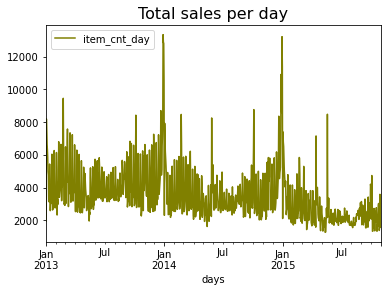

In [109]:
df_group_daily.plot(color="olive")
plt.title("Total sales per day", fontsize = 16)
plt.xlabel("days");

In [110]:
group_monthly= data_train.groupby('date_block_num')['item_cnt_day'].sum()
df_group_monthly= pd.DataFrame(group_monthly)
df_group_monthly.head()

,item_cnt_day
date_block_num,
0,131476.0
1,128090.0
2,147142.0
3,107190.0
4,106970.0


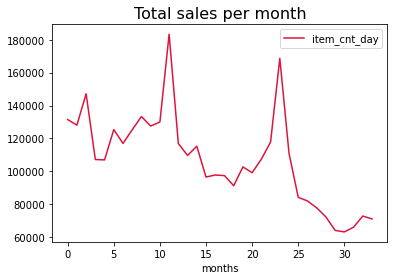

In [111]:
df_group_monthly.plot(color="crimson")
plt.title("Total sales per month", fontsize = 16)
plt.xlabel("months");

In [112]:
data_train['sales_income'] = data_train['item_price'] * data_train['item_cnt_day']
data_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category,sales_income
0,2013-01-02,0,59,22154,999.0,1.0,ярославль тц альтаир,ярославль,тц,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0
1,2013-01-02,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0
2,2013-01-03,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0
3,2013-01-20,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0
4,2013-01-23,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0


In [113]:
data_train["item_cnt_day"].min()

-22.0

In [114]:
data_train.loc[data_train["item_cnt_day"]<0].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category,sales_income
982,2013-12-27,11,59,5613,5571.0,-1.0,ярославль тц альтаир,ярославль,тц,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары,-5571.0
1050,2015-04-24,27,22,5613,6090.0,-1.0,москва магазин с21,москва,other,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары,-6090.0
1083,2015-04-21,27,18,5613,6090.0,-1.0,красноярск тц июнь,красноярск,тц,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары,-6090.0
1122,2014-09-06,20,28,5613,6090.0,-1.0,москва тц мега теплый стан ii,москва,тц,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары,-6090.0
1129,2015-02-17,25,28,5613,6090.0,-1.0,москва тц мега теплый стан ii,москва,тц,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары,-6090.0


In [115]:
monthly_sales_income= data_train.groupby(['date_block_num'])['sales_income'].sum()
df_monthly_sales_income= pd.DataFrame(monthly_sales_income)
df_monthly_sales_income.head()

,sales_income
date_block_num,
0,9.194649e+07
1,9.066571e+07
2,1.049327e+08
3,6.915429e+07
4,6.506531e+07


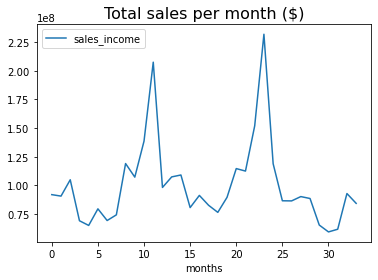

In [116]:
df_monthly_sales_income.plot()
plt.title("Total sales per month ($)", fontsize = 16)
plt.xlabel("months");

In [117]:
sales_item_per_shop = data_train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum()
df_sales_item_per_shop= pd.DataFrame(sales_item_per_shop)
df_sales_item_per_shop.head()

item_cnt_day
shop_id date_block_num              
2       0                     1146.0
        1                      488.0
        2                      753.0
        3                      583.0
        4                      553.0

In [118]:
sales_item_per_shop_per_item = data_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
df_sales_item_per_shop_per_item= pd.DataFrame(sales_item_per_shop_per_item)
df_sales_item_per_shop_per_item.head()

item_cnt_day
date_block_num shop_id item_id              
0              2       27                1.0
                       33                1.0
                       317               1.0
                       438               1.0
                       471               2.0

In [119]:
total_sales_item_per_shop = data_train.groupby(['shop_id'])['item_cnt_day'].sum()
df_total_sales_item_per_shop= pd.DataFrame(total_sales_item_per_shop)
df_total_sales_item_per_shop.head()

,item_cnt_day
shop_id,
2,30620.0
3,28355.0
4,43942.0
5,42762.0
6,100489.0


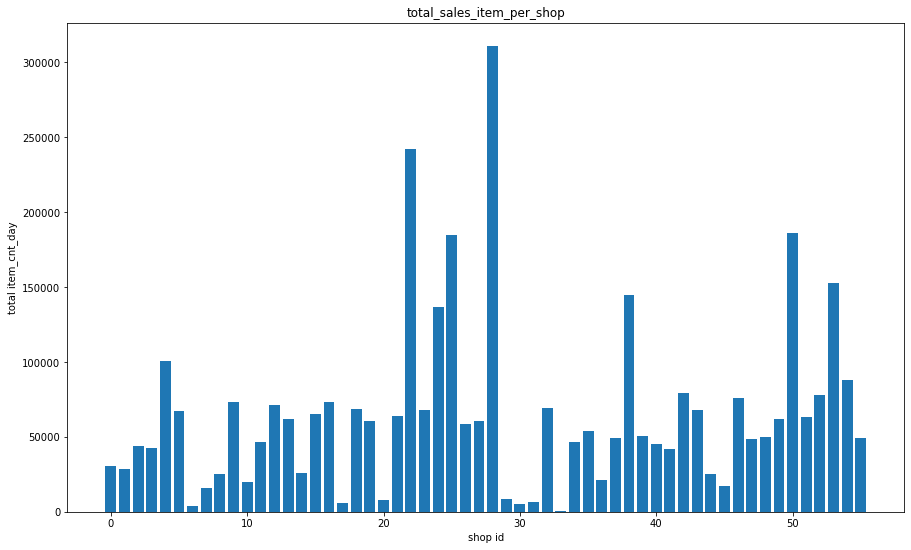

In [120]:
plt.figure(figsize=(15,9))
plt.bar(range(len(list(total_sales_item_per_shop))), list(total_sales_item_per_shop));
plt.xlabel("shop id")
plt.ylabel("total item_cnt_day")
plt.title("total_sales_item_per_shop")
plt.show()

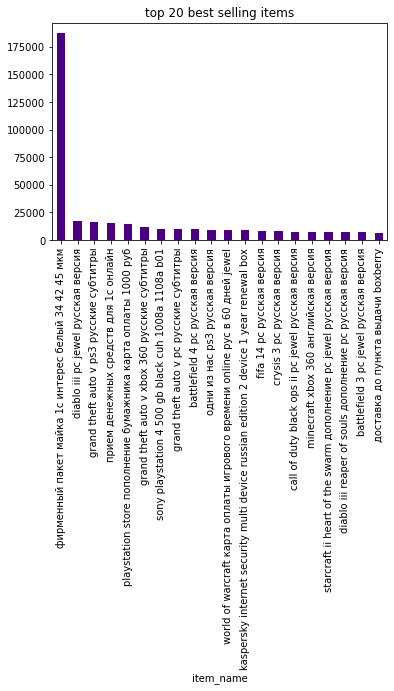

In [121]:
most_sold_items= data_train.groupby('item_name')['item_cnt_day'].sum().sort_values(ascending=False)
most_sold_items[0:20].plot(kind='bar', color='indigo')
plt.title("top 20 best selling items");

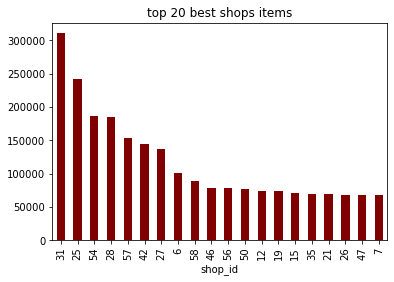

In [122]:
best_selling_shops= data_train.groupby('shop_id')['item_cnt_day'].sum().sort_values(ascending=False)
best_selling_shops[0:20].plot(kind='bar', color='maroon')
plt.title("top 20 best shops items");

In [123]:
data_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category,sales_income
0,2013-01-02,0,59,22154,999.0,1.0,ярославль тц альтаир,ярославль,тц,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0
1,2013-01-02,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0
2,2013-01-03,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0
3,2013-01-20,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0
4,2013-01-23,0,25,22154,999.0,1.0,москва трк атриум,москва,other,явление 2012 bd,37,Кино - Blu-Ray,Кино,999.0


In [124]:
data_train.drop(['sales_income'], axis=1, inplace=True)

In [125]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935658.0,14.569603,9.423149,0.0,7.0,14.0,23.0,33.0
shop_id,2935658.0,33.301341,16.147214,2.0,22.0,31.0,48.0,59.0
item_id,2935658.0,10194.905205,6325.175523,0.0,4475.0,9336.0,15684.0,22169.0
item_price,2935658.0,890.848184,1729.810250,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935658.0,1.242639,2.618904,-22.0,1.0,1.0,1.0,2169.0
item_category_id,2935658.0,40.000679,17.100210,0.0,28.0,40.0,55.0,83.0


In [126]:
data_train.shape

(2935658, 13)

# Handling Outliers

In [127]:
Numerical=data_train.select_dtypes(include='float64').columns.tolist()
Numerical

['item_price', 'item_cnt_day']

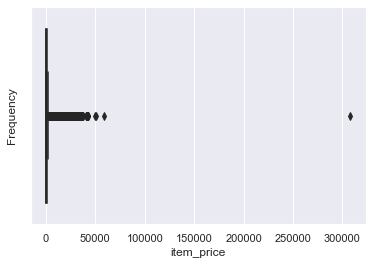

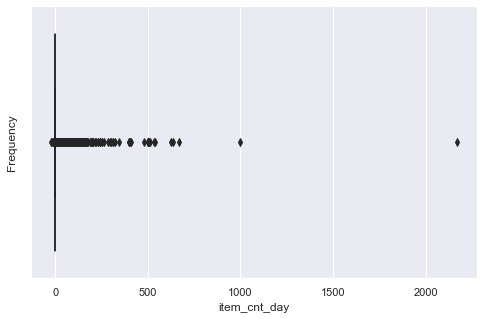

In [128]:
for i in Numerical:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(data_train[i], palette='dark');

In [129]:
data_train.sort_values(by="item_price").head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category
212573,2013-05-15,4,32,2973,-1.0000,1.0,москва тц серебряный дом,москва,тц,dmc devil may cry ps3 русские субтитры,19,Игры - PS3,Игры
1160457,2013-06-11,5,6,11864,0.0700,1.0,воронеж плехановская 13,воронеж,other,змей джекки с сердечком 36 см,63,Подарки - Мягкие игрушки,Подарки
1082169,2013-06-08,5,58,11865,0.0700,1.0,якутск тц центральный,якутск,тц,змей макс антистресс 33 см,63,Подарки - Мягкие игрушки,Подарки
2705024,2013-06-08,5,58,20146,0.0875,4.0,якутск тц центральный,якутск,тц,удавчик плюшевый 75см яйцо ткань,63,Подарки - Мягкие игрушки,Подарки
1204305,2013-07-31,6,6,11872,0.0900,1.0,воронеж плехановская 13,воронеж,other,змея василиса 23 см,63,Подарки - Мягкие игрушки,Подарки


In [130]:
data_train.sort_values(by="item_cnt_day").head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category
2593094,2013-11-02,10,12,8023,15.000000,-22.0,интернет магазин чс,интернет,other,zl004 лазерные наклейки смайлики маленькие,66,"Подарки - Открытки, наклейки",Подарки
925164,2014-07-10,18,14,20949,5.000000,-16.0,казань тц паркхаус ii,казань,тц,фирменный пакет майка 1с интерес белый 34 42 4...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",Подарки
2006978,2014-10-10,21,12,9242,1433.333333,-9.0,интернет магазин чс,интернет,other,билет игромир 2014 на один день отдельно 4 5 о...,8,Билеты (Цифра),etc
1351839,2013-10-19,9,42,3732,2599.000000,-6.0,спб тк невский центр,спб,тк,grand theft auto v ps3 русские субтитры,19,Игры - PS3,Игры
2895515,2013-01-18,0,12,1590,2599.000000,-6.0,интернет магазин чс,интернет,other,assassin s creed 3 freedom edition pc русская ...,29,Игры PC - Коллекционные издания,Игры


Extract data with a item_price greater than 0</br>
Extract data with a item_priceof less than 50,000</br></br>
Extract data with item_cnt_day greater than 0</br>
Extract data with item_cnt_day less than 1,000

In [131]:
outliers_list_P= np.where((data_train['item_price'] < 0)  | (data_train['item_price'] > 50000))
data_train.iloc[outliers_list_P]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category
212573,2013-05-15,4,32,2973,-1.0,1.0,москва тц серебряный дом,москва,тц,dmc devil may cry ps3 русские субтитры,19,Игры - PS3,Игры
2775999,2014-03-20,14,25,13199,50999.0,1.0,москва трк атриум,москва,other,коллекционные шахматы властелин колец,69,Подарки - Сувениры,Подарки
2895872,2013-09-17,8,12,11365,59200.0,1.0,интернет магазин чс,интернет,other,доставка ems,9,Доставка товара,etc
2897680,2013-12-13,11,12,6066,307980.0,1.0,интернет магазин чс,интернет,other,radmin 3 522 лиц,75,Программы - Для дома и офиса,Программы


In [132]:
outliers_list_C= np.where((data_train['item_cnt_day'] < 0)  | (data_train['item_cnt_day'] > 1000))
data_train.iloc[outliers_list_C].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category
982,2013-12-27,11,59,5613,5571.0,-1.0,ярославль тц альтаир,ярославль,тц,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары
1050,2015-04-24,27,22,5613,6090.0,-1.0,москва магазин с21,москва,other,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары
1083,2015-04-21,27,18,5613,6090.0,-1.0,красноярск тц июнь,красноярск,тц,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары
1122,2014-09-06,20,28,5613,6090.0,-1.0,москва тц мега теплый стан ii,москва,тц,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары
1129,2015-02-17,25,28,5613,6090.0,-1.0,москва тц мега теплый стан ii,москва,тц,ps3 гарнитура беспроводная для ps3 с поддержко...,2,Аксессуары - PS3,Аксессуары


In [133]:
data_train.iloc[outliers_list_P].min()

date                                     2013-05-15 00:00:00
date_block_num                                             4
shop_id                                                   12
item_id                                                 2973
item_price                                              -1.0
item_cnt_day                                             1.0
shop_name                                интернет магазин чс
city                                                интернет
shop_category                                          other
item_name             dmc devil may cry ps3 русские субтитры
item_category_id                                           9
item_category_name                           Доставка товара
category                                                 etc
dtype: object

In [134]:
data_train.iloc[outliers_list_C].min()

date                                  2013-01-01 00:00:00
date_block_num                                          0
shop_id                                                 2
item_id                                                28
item_price                                            0.5
item_cnt_day                                        -22.0
shop_name                                  адыгея тц мега
city                                               адыгея
shop_category                                       other
item_name             007 legends pс jewel русская версия
item_category_id                                        2
item_category_name                       Аксессуары - PS3
category                                              etc
dtype: object

In [135]:
# Extract data with a item_price greater than 0
data_train = data_train[data_train['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
data_train = data_train[data_train['item_price'] < 50001]
# Extract data with item_cnt_day greater than 0
data_train = data_train[data_train['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
data_train = data_train[data_train['item_cnt_day'] < 1001]

In [136]:
data_train.shape

(2928297, 13)

In [137]:
NEW_data_train= data_train.groupby(["date_block_num",'shop_id', 'city','shop_category','item_id', "item_category_id", "category",'item_price' ]).agg({'item_cnt_day' : 'sum'})
NEW_data_train.rename(columns = {'item_cnt_day' : 'monthly_sales'},inplace=True)
NEW_data_train.reset_index(inplace=True)
NEW_data_train

,date_block_num,shop_id,city,shop_category,item_id,item_category_id,category,item_price,monthly_sales
0,0,2,адыгея,тц,27,19,Игры,2499.0,1.0
1,0,2,адыгея,тц,33,37,Кино,499.0,1.0
2,0,2,адыгея,тц,317,45,Книги,299.0,1.0
3,0,2,адыгея,тц,438,45,Книги,299.0,1.0
4,0,2,адыгея,тц,471,49,Книги,399.0,2.0
...,...,...,...,...,...,...,...,...,...
1736975,33,59,ярославль,тц,22087,83,etc,119.0,6.0
1736976,33,59,ярославль,тц,22088,83,etc,119.0,2.0
1736977,33,59,ярославль,тц,22091,83,etc,179.0,1.0
1736978,33,59,ярославль,тц,22100,42,Книги,629.0,1.0


In [138]:
data_train.loc[(data_train.date_block_num==33) & 
                    (data_train.shop_id==59) &
                    (data_train.item_price==119) &
                    (data_train.item_id==22087)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,shop_category,item_name,item_category_id,item_category_name,category
386829,2015-10-05,33,59,22087,119.0,2.0,ярославль тц альтаир,ярославль,тц,элемент питания duracell lr03 bc2,83,Элементы питания,etc
386830,2015-10-18,33,59,22087,119.0,3.0,ярославль тц альтаир,ярославль,тц,элемент питания duracell lr03 bc2,83,Элементы питания,etc
386831,2015-10-23,33,59,22087,119.0,1.0,ярославль тц альтаир,ярославль,тц,элемент питания duracell lr03 bc2,83,Элементы питания,etc


# Handling the Variables

In [139]:
NEW_data_train.head()

,date_block_num,shop_id,city,shop_category,item_id,item_category_id,category,item_price,monthly_sales
0,0,2,адыгея,тц,27,19,Игры,2499.0,1.0
1,0,2,адыгея,тц,33,37,Кино,499.0,1.0
2,0,2,адыгея,тц,317,45,Книги,299.0,1.0
3,0,2,адыгея,тц,438,45,Книги,299.0,1.0
4,0,2,адыгея,тц,471,49,Книги,399.0,2.0


In [140]:
NEW_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736980 entries, 0 to 1736979
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   city              object 
 3   shop_category     object 
 4   item_id           int64  
 5   item_category_id  int64  
 6   category          object 
 7   item_price        float64
 8   monthly_sales     float64
dtypes: float64(2), int64(4), object(3)
memory usage: 119.3+ MB


In [141]:
NEW_data_train = NEW_data_train.astype({"date_block_num":str, "shop_id": str, "item_id":str, "item_category_id":str}, errors='raise')

In [142]:
NEW_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736980 entries, 0 to 1736979
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    object 
 1   shop_id           object 
 2   city              object 
 3   shop_category     object 
 4   item_id           object 
 5   item_category_id  object 
 6   category          object 
 7   item_price        float64
 8   monthly_sales     float64
dtypes: float64(2), object(7)
memory usage: 119.3+ MB


## Numerical Variables

In [143]:
Num=NEW_data_train.select_dtypes(exclude='object').columns.tolist()
Num

['item_price', 'monthly_sales']

In [144]:
from sklearn.impute import SimpleImputer

In [145]:
Num_impute= SimpleImputer(strategy="median")

In [146]:
# Num[0] >>> 'item_price'
NEW_data_train[Num[0]] = Num_impute.fit_transform(NEW_data_train[[Num[0]]])

In [147]:
from sklearn.preprocessing import StandardScaler

In [148]:
Num_scaler= StandardScaler()

In [149]:
# Num[0] >>> 'item_price'
NEW_data_train[Num[0]] = Num_scaler.fit_transform(NEW_data_train[[Num[0]]])

In [150]:
NEW_data_train.head()

,date_block_num,shop_id,city,shop_category,item_id,item_category_id,category,item_price,monthly_sales
0,0,2,адыгея,тц,27,19,Игры,0.972150,1.0
1,0,2,адыгея,тц,33,37,Кино,-0.202992,1.0
2,0,2,адыгея,тц,317,45,Книги,-0.320507,1.0
3,0,2,адыгея,тц,438,45,Книги,-0.320507,1.0
4,0,2,адыгея,тц,471,49,Книги,-0.261750,2.0


## Categorical Variables

In [151]:
Cat=NEW_data_train.select_dtypes(include='object').columns.tolist()
Cat

['date_block_num',
 'shop_id',
 'city',
 'shop_category',
 'item_id',
 'item_category_id',
 'category']

In [152]:
from sklearn.impute import SimpleImputer

In [153]:
Cat_impute= SimpleImputer(strategy="most_frequent")

In [154]:
for columns in Cat:
    NEW_data_train[columns] = Cat_impute.fit_transform(NEW_data_train[[columns]])

In [155]:
from sklearn.preprocessing import LabelEncoder

In [156]:
NEW_data_train = NEW_data_train.apply(lambda x: LabelEncoder().fit_transform(x) if x.dtype == 'object' else x)
NEW_data_train.head()

,date_block_num,shop_id,city,shop_category,item_id,item_category_id,category,item_price,monthly_sales
0,0,9,0,3,13777,11,3,0.972150,1.0
1,0,9,0,3,14432,31,5,-0.202992,1.0
2,0,9,0,3,14293,40,6,-0.320507,1.0
3,0,9,0,3,15609,40,6,-0.320507,1.0
4,0,9,0,3,15973,44,6,-0.261750,2.0


In [157]:
NEW_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736980 entries, 0 to 1736979
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int32  
 1   shop_id           int32  
 2   city              int32  
 3   shop_category     int32  
 4   item_id           int32  
 5   item_category_id  int32  
 6   category          int32  
 7   item_price        float64
 8   monthly_sales     float64
dtypes: float64(2), int32(7)
memory usage: 72.9 MB


# Splitting the Dataset

In [158]:
X= NEW_data_train.drop(["monthly_sales"], axis=1)
y= NEW_data_train.monthly_sales

In [159]:
X.head()

,date_block_num,shop_id,city,shop_category,item_id,item_category_id,category,item_price
0,0,9,0,3,13777,11,3,0.972150
1,0,9,0,3,14432,31,5,-0.202992
2,0,9,0,3,14293,40,6,-0.320507
3,0,9,0,3,15609,40,6,-0.320507
4,0,9,0,3,15973,44,6,-0.261750


In [160]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    2.0
Name: monthly_sales, dtype: float64

In [161]:
from sklearn.model_selection import train_test_split

In [163]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

# Model Building

Models will be trained with default parameters:

## KNeighbors Regressor

In [164]:
from sklearn.neighbors import KNeighborsRegressor

In [165]:
%%time
KNNReg= KNeighborsRegressor()
KNNReg.fit(X_train, y_train)
print('KNeighborsRegressor model trained')

KNeighborsRegressor model trained
CPU times: total: 9.14 s
Wall time: 9.19 s


## Random Forest Regressor

In [166]:
from sklearn.ensemble import RandomForestRegressor

In [167]:
%%time
RanForReg= RandomForestRegressor()
RanForReg.fit(X_train, y_train)
print('RandomForestRegressor model trained')

RandomForestRegressor model trained
CPU times: total: 13min 34s
Wall time: 13min 38s


## Gradient Boosting Regressor

In [173]:
from sklearn.ensemble import GradientBoostingRegressor

In [174]:
%%time
GBReg= GradientBoostingRegressor()
GBReg.fit(X_train, y_train)
print('GBRegressor model trained')

GBRegressor model trained
CPU times: total: 3min 46s
Wall time: 3min 54s


## XGBoost Regressor

In [168]:
!pip install xgboost
from xgboost import XGBRegressor, plot_importance

In [169]:
%%time
XGBReg= XGBRegressor()
XGBReg.fit(X_train, y_train)
print('XGBRegressor model trained')

XGBRegressor model trained
CPU times: total: 6min 52s
Wall time: 1min 59s


# Model Evaluation

In [170]:
%%time
print("KNN scores:")
print("KNN train test score: ", KNNReg.score(X_train, y_train))
print("KNN valid test score: ", KNNReg.score(X_valid, y_valid))

KNN scores:
KNN train test score:  0.5914682518386605
KNN valid test score:  0.43602511956292145
CPU times: total: 55.7 s
Wall time: 1min 9s


In [172]:
%%time
print("Random Forest scores:")
print("RF train test score: ", RanForReg.score(X_train, y_train))
print("RF valid test score: ", RanForReg.score(X_valid, y_valid))

Random Forest scores:
RF train test score:  0.9498204214765399
RF valid test score:  0.6291876354542107
CPU times: total: 2min 38s
Wall time: 6min 35s


In [175]:
%%time
print("GB scores:")
print("GB train test score: ", GBReg.score(X_train, y_train))
print("GB valid test score: ", GBReg.score(X_valid, y_valid))

GB scores:
GB train test score:  0.40350700549752305
GB valid test score:  0.3698874379432747
CPU times: total: 2.89 s
Wall time: 3.35 s


In [171]:
%%time
print("XGB scores:")
print("XGB train test score: ", XGBReg.score(X_train, y_train))
print("XGB valid test score: ", XGBReg.score(X_valid, y_valid))

XGB scores:
XGB train test score:  0.7389014446639393
XGB valid test score:  0.6278856620725417
CPU times: total: 9.47 s
Wall time: 2.7 s


MAPE calculations for top 2 models:

In [177]:
# Make predictions on test data
RF_predictions = RanForReg.predict(X_valid)
# Performance metrics
RF_errors = abs(RF_predictions - y_valid)
print('Metrics for Random Forest')
print('Average absolute error:', round(np.mean(RF_errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
RF_mape = np.mean(100 * (RF_errors / y_valid))

Metrics for Random Forest
Average absolute error: 1.01 degrees.


In [178]:
RF_mape

48.50908743767787

In [180]:
# Make predictions on test data
XGB_predictions = XGBReg.predict(X_valid)
# Performance metrics
XGB_errors = abs(XGB_predictions - y_valid)
print('Metrics for XGB')
print('Average absolute error:', round(np.mean(XGB_errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
XGB_mape = np.mean(100 * (XGB_errors / y_valid))

Metrics for XGB
Average absolute error: 1.17 degrees.


In [181]:
XGB_mape

60.02220980422689

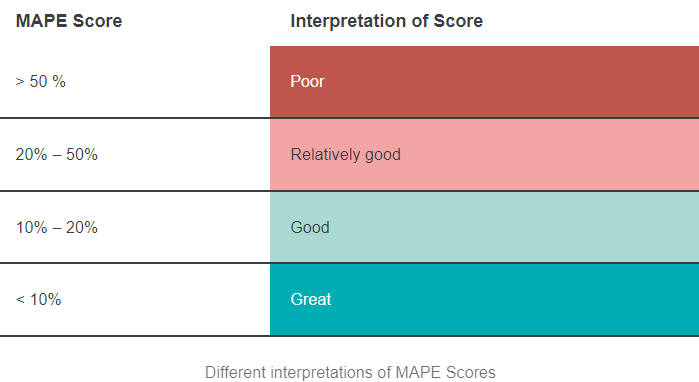

Source: https://datagy.io/mape-python/

From the outputs above, it looks like the Random Forest (RF) Regressor performs the best (Although not performing very well).

From this point onward, it will be built the regression algorithm using the RF Regressor. 

The RF will be tested with a few hyperparameters using the GridSearchCV function.

# Hyperparameter Optimization

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

RF_param_grid = { 
    'n_estimators': [500, 1500],
    'max_depth' : [5, 15]
}
RF_GridCV = GridSearchCV(RanForReg, RF_param_grid, cv=3, n_jobs= -1)
RF_GridCV.fit(X_train,y_train)  
print(RF_GridCV.best_params_)    
print(RF_GridCV.best_score_)